# #3. PLS Regression

* 변수간의 상관관계를 고려하는 PLS Regression 적합과정입니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json
import pathlib
import pickle
import os
current_path = os.getcwd()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime, timedelta
import statistics
import time

import pymysql  
from haversine import haversine
from bisect import bisect_left, bisect_right

from geoband.API import *
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster, MarkerCluster
import geoplot as gplt
import geoplot.crs as gcrs
import imageio
import mapclassify as mc

import random
from functools import reduce
from collections import defaultdict

from IPython.display import display
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

import pydeck as pdk
import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

import shapely
from shapely import wkt
from shapely.geometry import Polygon, Point, shape

# NLP 
import re
from konlpy.tag import Okt

!pip install glove_python
from glove import Corpus, Glove

# Crawling 
import requests
from bs4 import BeautifulSoup

# Clustering 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn import metrics
from scipy.spatial.distance import cdist

# 최적화 solver
from mip import Model, xsum, maximize, BINARY  

# font 
import matplotlib.font_manager as font_manager
path = current_path+'/NanumBarunGothic.ttf'
fontprop = font_manager.FontProperties(fname=path)

font_dirs = [current_path, ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
plt.style.context('default')
plt.rcParams["font.family"] = 'NanumBarunGothic'
mpl.rcParams['font.family'] = 'NanumBarunGothic'

Using Python-MIP package version 1.5.3


In [2]:
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# Data Load 
df_01 = pd.read_csv(current_path+'/input/1.수원시_버스정류장.csv')
df_02 = pd.read_csv(current_path+'/input/2.수원시_버스정류장별_승하차이력(1).csv')
df_03 = pd.read_csv(current_path+'/input/3.수원시_버스정류장별_승하차이력(2).csv')
df_04 = pd.read_csv(current_path+'/input/4.수원시_버스정류장별_승하차이력(3).csv')
df_05 = pd.read_csv(current_path+'/input/5.수원시_버스정류장별_승하차이력(4).csv')
df_06 = pd.read_csv(current_path+'/input/6.수원시_버스정류장별_승하차이력(5).csv')
df_07 = pd.read_csv(current_path+'/input/7.수원시_버스정류장별_노선현황.csv')
df_08 = pd.read_csv(current_path+'/input/8.수원시_지하철역_위치정보.csv')
df_09 = pd.read_csv(current_path+'/input/9.수원시_지하철역별_이용현황(2017~2019).csv')
df_10 = pd.read_csv(current_path+'/input/10.수원시_옥외광고물현황.csv')
df_11 = pd.read_csv(current_path+'/input/11.수원시_대기오염도_측정현황.csv')
df_12 = pd.read_csv(current_path+'/input/12.수원시_주차장현황.csv')
df_13 = pd.read_csv(current_path+'/input/13.수원시_기상데이터(2020).csv')
df_14 = pd.read_csv(current_path+'/input/14.수원시_시간대별_유동인구(2020).csv')
df_15 = pd.read_csv(current_path+'/input/15.수원시_성연령별_유동인구(2020).csv')
df_16 = pd.read_csv(current_path+'/input/16.수원시_요일별_유동인구(2020).csv')
df_17 = gpd.read_file(current_path+'/input/17.수원시_인구정보(고령)_격자.geojson')
df_18 = gpd.read_file(current_path+'/input/18.수원시_인구정보(생산가능)_격자.geojson')
df_19 = gpd.read_file(current_path+'/input/19.수원시_인구정보(유소년)_격자.geojson')
df_20 = gpd.read_file(current_path+'/input/20.수원시_교통노드.geojson')
df_21 = gpd.read_file(current_path+'/input/21.수원시_교통링크.geojson')
df_22 = gpd.read_file(current_path+'/input/22.수원시_상세도로망_LV6.geojson')
df_23 = pd.read_csv(current_path+'/input/23.수원시_평일_일별_시간대별_추정교통량_LV6.csv')
df_24 = pd.read_csv(current_path+'/input/24.수원시_평일_일별_혼잡빈도강도_LV6.csv')
df_25 = pd.read_csv(current_path+'/input/25.수원시_평일_일별_혼잡시간강도_LV6.csv')
df_26 = gpd.read_file(current_path+'/input/26.수원시_인도(2017).geojson')
df_27 = gpd.read_file(current_path+'/input/27.수원시_도로명주소(건물).geojson')
df_28 = gpd.read_file(current_path+'/input/28.수원시_건물연면적_격자.geojson')
df_29 = gpd.read_file(current_path+'/input/29.수원시_법정경계(시군구).geojson')
df_30 = gpd.read_file(current_path+'/input/30.수원시_법정경계(읍면동).geojson')
df_31 = gpd.read_file(current_path+'/input/31.수원시_행정경계(읍면동).geojson')
df_32 = gpd.read_file(current_path+'/input/32.수원시_지적도.geojson')

In [4]:
paldal = pd.read_excel(current_path+'/busdata/bustarget_paldal.xlsx')
jangan = pd.read_excel(current_path+'/busdata/bustarget_jangan.xlsx')
gs = pd.read_excel(current_path+'/busdata/bustarget_gs.xlsx')
yt = pd.read_excel(current_path+'/busdata/bustarget_yt.xlsx')

In [5]:
paldal.head(2)

,정류소ID,정류장명,lon,lat,위치(동),쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수,kmeans,spca_component_1,spca_component_2,spca_component_3
0,201000287,매교역4번출구.경기도박치료센터,127.015063,37.265523,경기도 수원시 매교동,1,0,0,1,0,0,5,1,3.827397,0.792482,0.866325,0.207518,0.227554,1.093879,0.413318,0.108385,0.478297,135.810423,108.311571,27.498852,130.443981,0,0,0,3,0,0,0,0,0,17.750000,18.416667,23.500000,0.413929,0.106740,0.479331,301.150813,2,0,294.791444,0,0,0,1411.080046,55.000000,37.833333,0.411326,0.116150,0.472524,193.780000,2,1,192.610101,0,0,0,1341.294231,90.000000,0.428358,0.106404,0.465238,170.611111,0,0,0,1241.472222,0.000625,0.192887,0.010283,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,1,3872030,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1996,59,4,27000,454,1026.466667,870.653333,8.333333,147.433333,19.075000,50.520000,43.660417,71.615000,64.093333,79.136667,32.430000,97.967500,104.438333,109.963333,112.700833,132.395833,29.766667,103.295833,76.714167,75.082500,78.803333,94.298333,1056.548167,1028.362083,443.737721,0,0,0,0,0.000000,0.000000,0.000000,0,0,5,12,0,6,0,0,0,0,0,1,0,0,0,0,163.309275,2,-5.982865,-0.566526,2.389086
1,202000011,중소기업은행,127.033395,37.266237,경기도 수원시 인계동,1,0,0,1,0,0,13,1,4.286277,0.788806,0.401787,0.211194,0.112779,0.514566,0.232416,0.066355,0.701230,809.212526,640.270891,168.941635,1112.889704,0,0,0,7,0,3,0,0,3,19.000000,18.750000,22.350000,0.232281,0.069324,0.698395,2209.304947,4,0,741.822564,0,0,3,9868.925673,45.000000,30.350000,0.234740,0.055074,0.710185,1322.453030,3,2,531.029322,0,0,3,8042.133984,72.500000,0.229927,0.053895,0.716178,1122.005983,0,0,4,6734.994925,-0.043330,0.094638,0.061255,38.791667,24.000000,0.024750,0.027375,0.003000,0.629167,1,3576596,48.166667,25.000000,32.666667,49.333333,27.833333,16.666667,18.000000,33.500000,2014,15,9,7800,519,1575.224000,1323.068000,16.392000,235.732000,33.020000,67.493000,56.932292,75.897222,56.370000,95.424444,36.202500,115.939167,162.910833,178.048333,146.736667,114.762500,42.260833,103.095833,121.162500,151.446667,113.317500,80.479167,1311.896167,1503.891667,630.778358,0,0,101,0,0.000000,1.000000,0.000000,1,1,0,33,0,0,0,0,0,0,0,0,0,0,1,0,978.154162,2,-8.997537,2.574102,1.267798


## 1. PLSRegression

### 1. 팔달구

* 원래 값

In [6]:
pd.set_option('max_seq_items', 150)

In [7]:
paldal.shape

(37, 148)

In [8]:
paldal.columns

Index(['정류소ID', '정류장명', 'lon', 'lat', '위치(동)', '쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형', '중앙차로여부', '운행노선수', '정류장유형수', '초승_환승비율', '초승_승차비율', '초승_하차비율', '환승_승차비율', '환승_하차비율', '승차_하차비율', '승차비율', '환승비율', '하차비율', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수', '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '승차많은버스', '환승많은버스', '하차많은버스', '상행버스정류장운행시간', '하행버스정류장운행시간', '주중배차간격(분)', '주중승차비율', '주중환승비율', '주중하차비율', '주중전체승하차건수', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수', '주중승차많은버스', '주중환승많은버스', '주중하차많은버스', '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말승차비율', '주말환승비율', '주말하차비율', '주말전체승하차건수', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', '주말승차많은버스', '주말환승많은버스', '주말하차많은버스', '주말대기시간노출도', '평균주말배차간격', '공휴일승차비율', '공휴일환승비율', '공휴일하차비율', '공휴일전체승하차건수', '공휴일승차많은버스', '공휴일환승많은버스', '공휴일하차많은버스', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름', '미세_가을', '미세_겨울',
  

In [9]:
paldal_X = paldal.drop(['정류소ID', '정류장명', 'lon', 'lat', '위치(동)',
             '초승_환승비율', '초승_승차비율', '초승_하차비율', '환승_승차비율', '환승_하차비율', '승차_하차비율', 
             '승차비율', '환승비율', '하차비율', '전체 승차 건수', '초승 건수', '환승 건수', '전체 하차 건수',
             '승차많은버스', '환승많은버스', '하차많은버스', '주중승차비율', '주중환승비율', '주중하차비율', '주중전체승하차건수',
             '주중승차많은버스', '주중환승많은버스', '주중하차많은버스', '주말승차비율', '주말환승비율', '주말하차비율', '주말전체승하차건수',
             '주말승차많은버스', '주말환승많은버스', '주말하차많은버스', '공휴일승차비율', '공휴일환승비율', '공휴일하차비율', 
             '공휴일전체승하차건수', '공휴일승차많은버스', '공휴일환승많은버스', '공휴일하차많은버스',
             '전체_추정교통량_전체시간', '승용차_추정교통량_전체시간', '버스_추정교통량_전체시간', '화물차_추정교통량_전체시간', 
             '유동인구_전체', '유동인구_출퇴근', '유동인구_출근', '유동인구_퇴근', '남자10대유동인구', '남자20대유동인구', 
             '남자30대유동인구', '남자40대유동인구', '남자50대유동인구', '남자60대유동인구', '여자10대유동인구', '여자20대유동인구', 
             '여자30대유동인구', '여자40대유동인구', '여자50대유동인구', '여자60대유동인구', 'pop_평일', 'pop_주말', '전체승하차건수',
             'kmeans', 'spca_component_1', 'spca_component_2', 'spca_component_3'], axis = 1)

In [10]:
paldal_X.shape

(37, 79)

In [11]:
paldal_X.columns

Index(['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형', '중앙차로여부', '운행노선수', '정류장유형수', '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수', '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름', '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도', '디지털정보지수', '주차구획수', '고령인구', '생산가능인구', '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9'], dtype='object')

In [12]:
Y = paldal[['전체_추정교통량_전체시간', '유동인구_전체', '전체 승차 건수']]
X = paldal[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

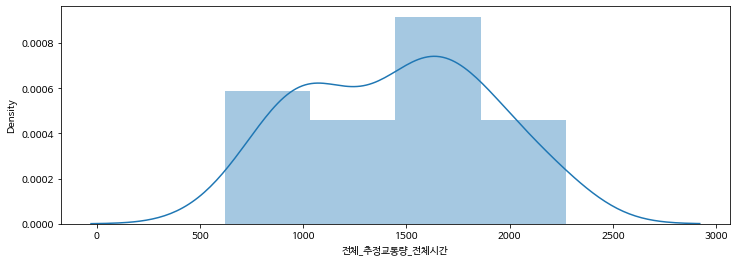

In [13]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체_추정교통량_전체시간'])
plt.rc('axes', unicode_minus=False)
plt.show()

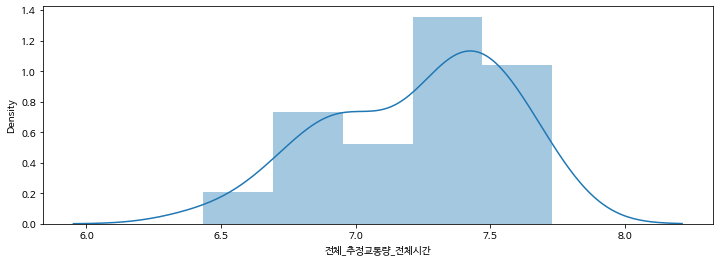

In [14]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체_추정교통량_전체시간']))
plt.rc('axes', unicode_minus=False)
plt.show()

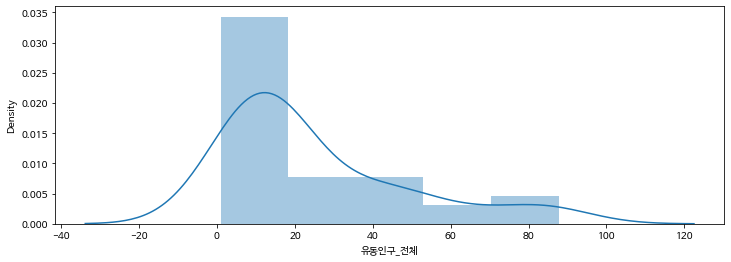

In [15]:
plt.figure(figsize=(12,4))
sns.distplot(Y['유동인구_전체'])
plt.rc('axes', unicode_minus=False)
plt.show()

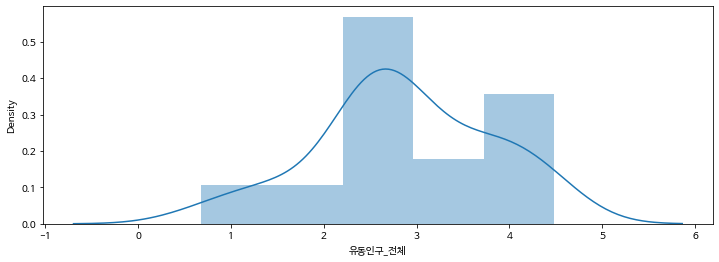

In [16]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['유동인구_전체']))
plt.rc('axes', unicode_minus=False)
plt.show()

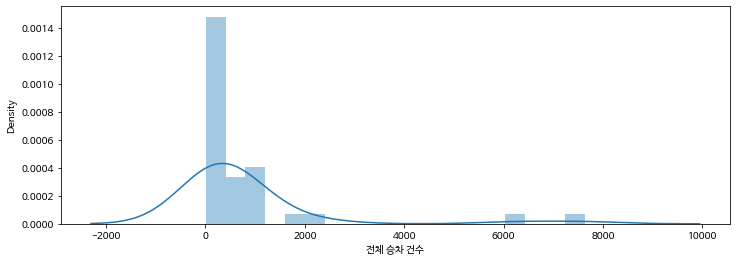

In [17]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체 승차 건수'])
plt.rc('axes', unicode_minus=False)
plt.show()

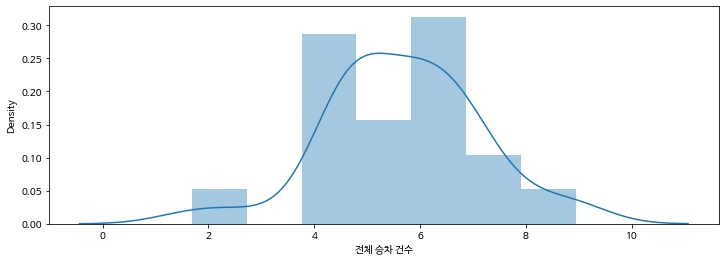

In [18]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체 승차 건수']))
plt.show()

In [19]:
def optimise_pls_cv(X, y, n_comp):
    # Define PLS object
    pls = PLSRegression(n_components=n_comp)

    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)

    # Calculate scores
    r2 = r2_score(y, y_cv)
    mse = mean_squared_error(y, y_cv)
    rpd = y.std()/np.sqrt(mse)
    
    return (y_cv, r2, mse, rpd)

In [20]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:06<00:00,  5.91it/s]


In [21]:
# Plot the mses
def plot_metrics(vals, ylabel, objective, location, optim):
    optim = optim - 1
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(1, len(r2s) + 1), np.array(vals), color = 'navy')
    if objective=='min':
        idx = np.argmin(vals)
    else:
        idx = np.argmax(vals)
    plt.axvline(np.arange(1, len(r2s) + 1)[optim], linestyle = '--', color = '0.5', linewidth = 1)
    plt.plot(np.arange(1, len(r2s) + 1)[optim], np.array(vals)[optim], 'o', ms=5, mfc='red', mec='red')
    plt.rc('axes', unicode_minus=False)
    plt.xlabel('Number of PLS components')
    plt.xticks = np.arange(1, len(r2s) + 1)
    plt.ylabel(ylabel)
    plt.title(f'{location}')

    plt.show()

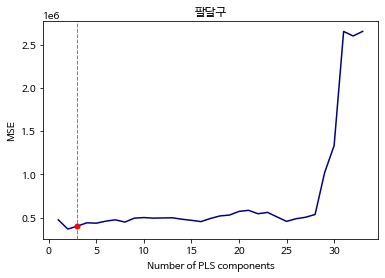

In [22]:
plot_metrics(mses, 'MSE', 'min', '팔달구', 3)

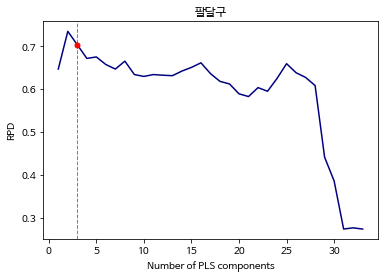

In [23]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '팔달구', 3)

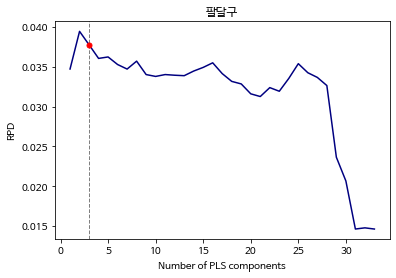

In [24]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '팔달구', 3)

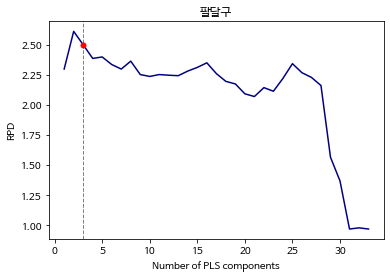

In [25]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '팔달구', 3)

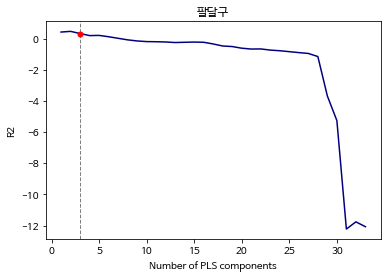

In [26]:
plot_metrics(r2s, 'R2', 'max', '팔달구', 3)

In [27]:
pls = PLSRegression(n_components=3)
pls.fit(X, Y)
y_pred = pls.predict(X)

In [28]:
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
rpd = Y.std()/np.sqrt(mse)

In [29]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.7225, MSE: 105608.1540


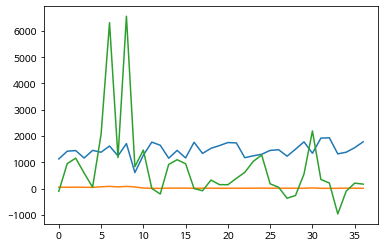

In [30]:
plt.plot(pd.DataFrame(y_pred, columns = Y.columns))
plt.rc('axes', unicode_minus=False)
plt.show()

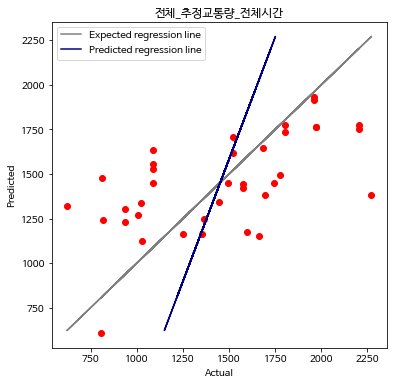

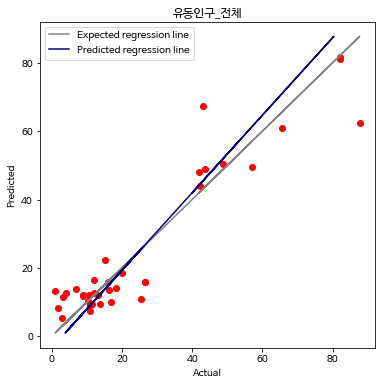

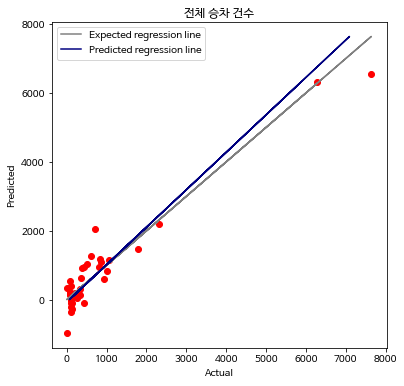

In [31]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(Y).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(Y).iloc[:,i]), pd.DataFrame(Y).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

* 로그

In [32]:
paldal['log_전체_추정교통량_전체시간'] = np.log1p(paldal['전체_추정교통량_전체시간'])
paldal['log_유동인구_전체'] = np.log1p(paldal['유동인구_전체'])
paldal['log_전체_승차_건수'] = np.log1p(paldal['전체 승차 건수'])

In [33]:
logY = paldal[['log_전체_추정교통량_전체시간', 'log_유동인구_전체', 'log_전체_승차_건수']]
X = paldal[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [34]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:06<00:00,  6.09it/s]


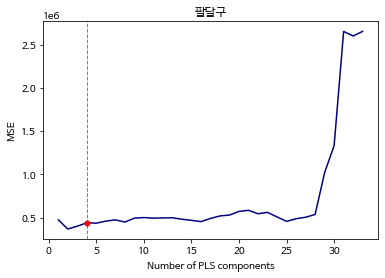

In [35]:
plot_metrics(mses, 'MSE', 'min', '팔달구', 4)

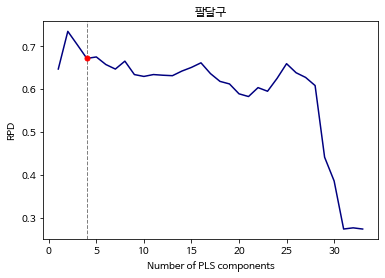

In [36]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '팔달구', 4)

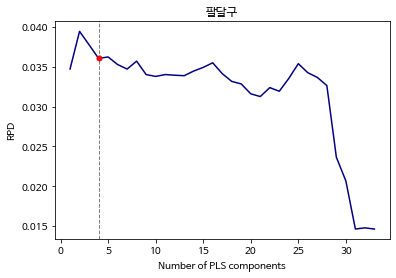

In [37]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '팔달구', 4)

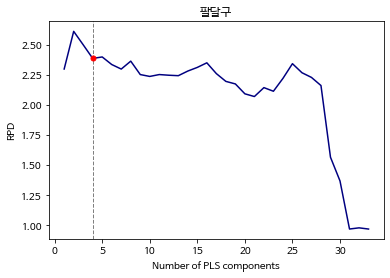

In [38]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '팔달구', 4)

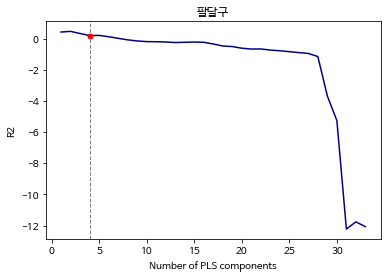

In [39]:
plot_metrics(r2s, 'R2', 'max', '팔달구', 4)

In [40]:
pls = PLSRegression(n_components=4)
pls.fit(X, logY)
y_pred = pls.predict(X)

In [41]:
r2 = r2_score(Y, np.expm1(y_pred))
mse = mean_squared_error(Y, np.expm1(y_pred))
rpd = Y.std()/np.sqrt(mse)

In [42]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.7194, MSE: 187865.3472


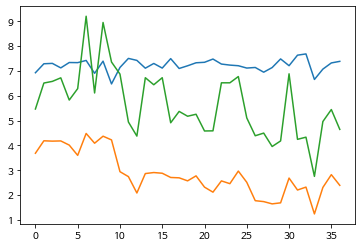

In [43]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

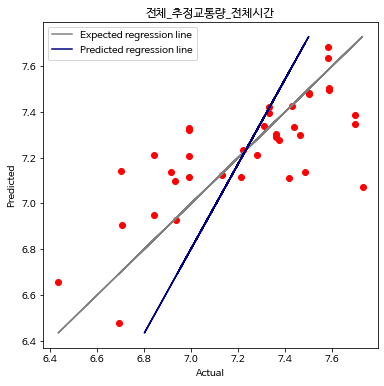

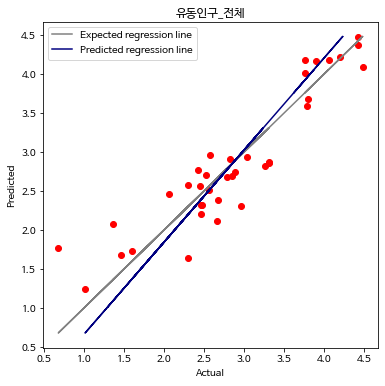

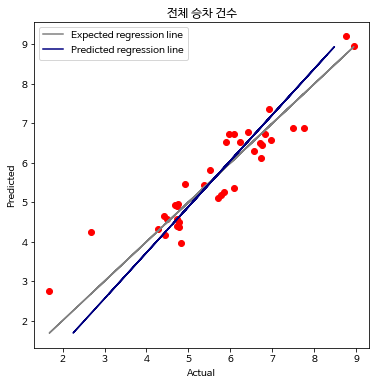

In [44]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(logY).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(logY).iloc[:,i]), pd.DataFrame(logY).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

* 지수

In [45]:
from sklearn.preprocessing import MinMaxScaler

In [46]:
scaler = MinMaxScaler()
yhat_scale = scaler.fit_transform(np.expm1(y_pred))
paldal['pred_교통량'] = pd.DataFrame(yhat_scale).iloc[:,0]
paldal['pred_유동인구'] = pd.DataFrame(yhat_scale).iloc[:,1]
paldal['pred_승차건수'] = pd.DataFrame(yhat_scale).iloc[:,2]
paldal['smart'] = paldal['pred_교통량'] + paldal['pred_유동인구'] + paldal['pred_승차건수']

### 2. 장안구

* 원래 값

In [47]:
Y = jangan[['전체_추정교통량_전체시간', '유동인구_전체', '전체 승차 건수']]
X = jangan[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [48]:
X.shape

(29, 79)

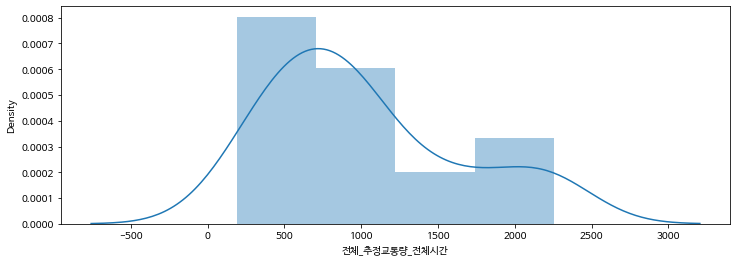

In [49]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체_추정교통량_전체시간'])
plt.rc('axes', unicode_minus=False)
plt.show()

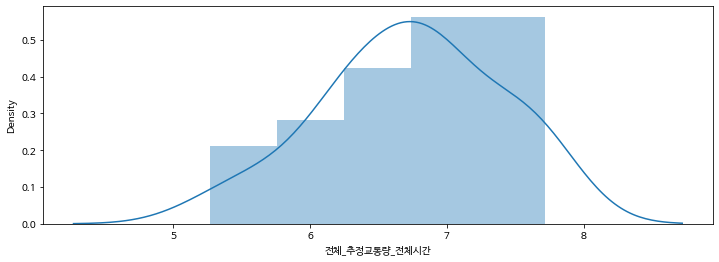

In [50]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체_추정교통량_전체시간']))
plt.rc('axes', unicode_minus=False)
plt.show()

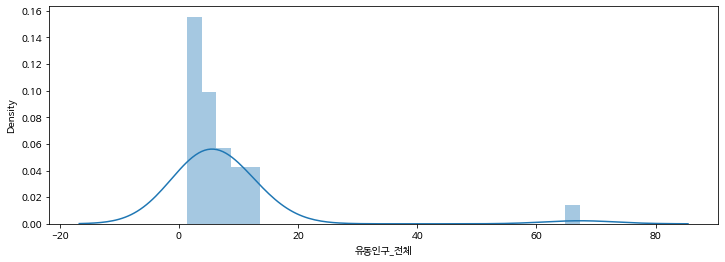

In [51]:
plt.figure(figsize=(12,4))
sns.distplot(Y['유동인구_전체'])
plt.rc('axes', unicode_minus=False)
plt.show()

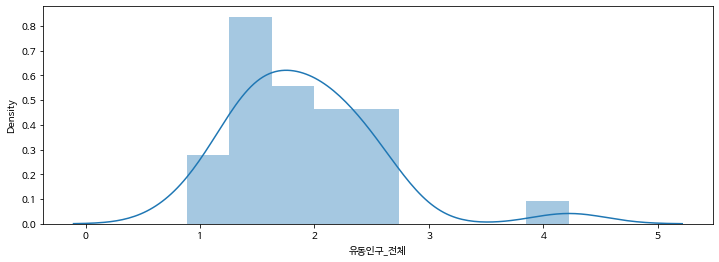

In [52]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['유동인구_전체']))
plt.rc('axes', unicode_minus=False)
plt.show()

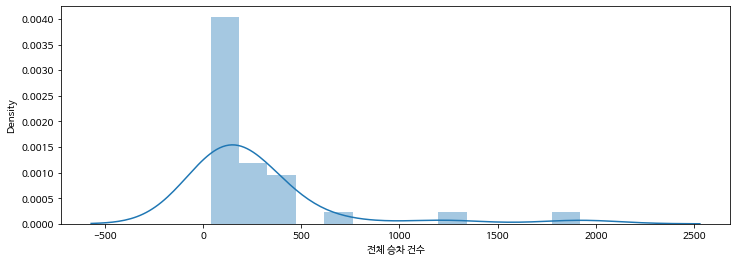

In [53]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체 승차 건수'])
plt.rc('axes', unicode_minus=False)
plt.show()

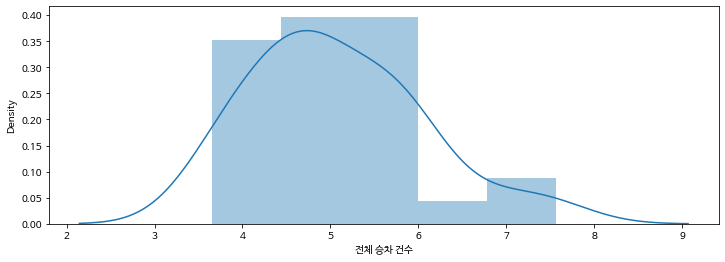

In [54]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체 승차 건수']))
plt.rc('axes', unicode_minus=False)
plt.show()

In [55]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


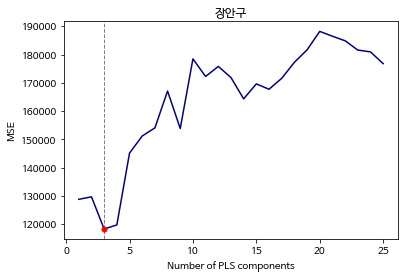

In [56]:
plot_metrics(mses, 'MSE', 'min', '장안구', 3)

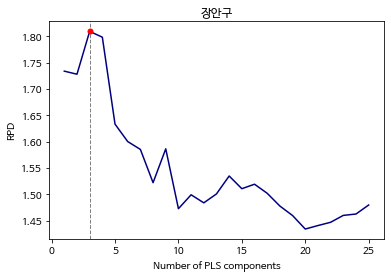

In [57]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '장안구', 3)

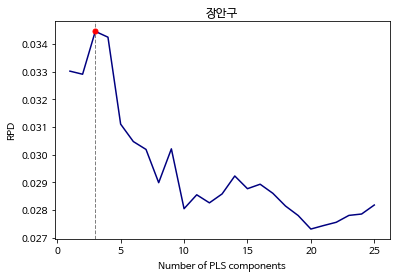

In [58]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '장안구', 3)

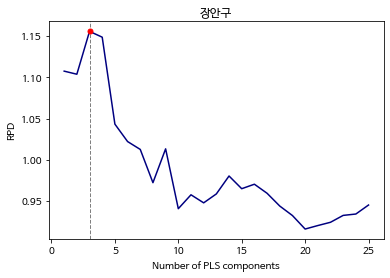

In [59]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '장안구', 3)

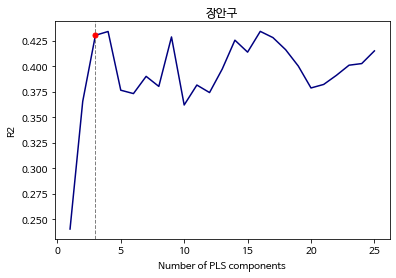

In [60]:
plot_metrics(r2s, 'R2', 'max', '장안구', 3)

In [61]:
pls = PLSRegression(n_components=3)
pls.fit(X, Y)
y_pred = pls.predict(X)

In [62]:
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
rpd = Y.std()/np.sqrt(mse)

In [63]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.8420, MSE: 42979.9124


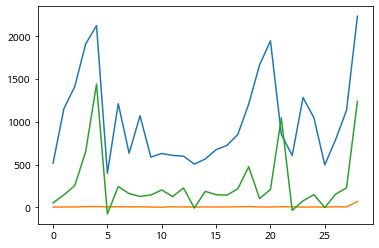

In [64]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

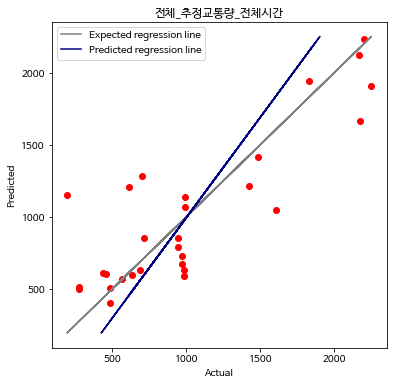

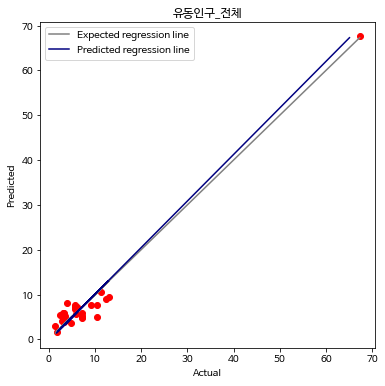

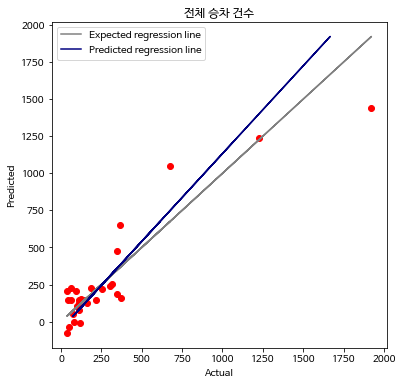

In [65]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(Y).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(Y).iloc[:,i]), pd.DataFrame(Y).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

* 로그

In [66]:
jangan['log_전체_추정교통량_전체시간'] = np.log1p(jangan['전체_추정교통량_전체시간'])
jangan['log_유동인구_전체'] = np.log1p(jangan['유동인구_전체'])
jangan['log_전체_승차_건수'] = np.log1p(jangan['전체 승차 건수'])

In [67]:
logY = jangan[['log_전체_추정교통량_전체시간', 'log_유동인구_전체', 'log_전체_승차_건수']]
X = jangan[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [68]:
X.shape

(29, 79)

In [69]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


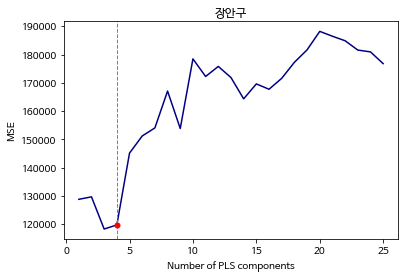

In [70]:
plot_metrics(mses, 'MSE', 'min', '장안구', 4)

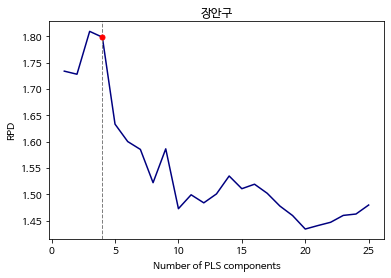

In [71]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '장안구', 4)

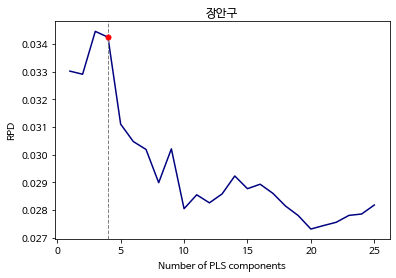

In [72]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '장안구', 4)

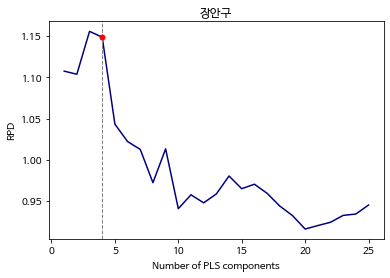

In [73]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '장안구', 4)

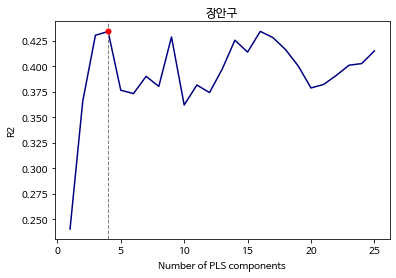

In [74]:
plot_metrics(r2s, 'R2', 'max', '장안구', 4)

In [75]:
pls = PLSRegression(n_components = 4)
pls.fit(X, logY)
y_pred = pls.predict(X)

In [76]:
r2 = r2_score(Y, np.expm1(y_pred))
mse = mean_squared_error(Y, np.expm1(y_pred))
rpd = Y.std()/np.sqrt(mse)

In [77]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.9106, MSE: 26553.7553


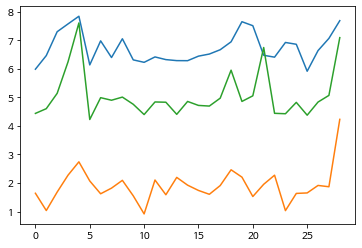

In [78]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

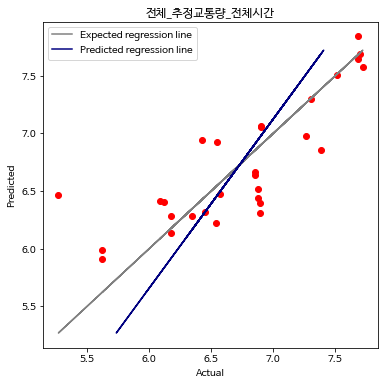

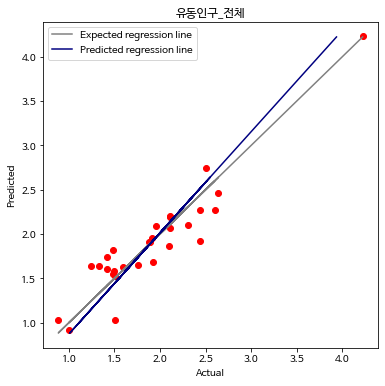

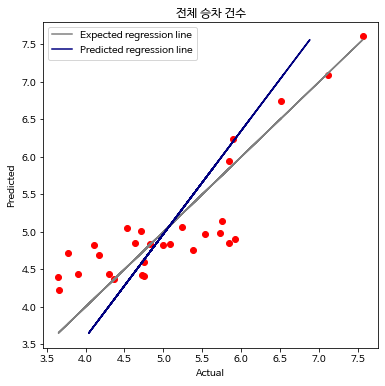

In [79]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(logY).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(logY).iloc[:,i]), pd.DataFrame(logY).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

* 지수

In [80]:
scaler = MinMaxScaler()
yhat_scale = scaler.fit_transform(np.expm1(y_pred))
jangan['pred_교통량'] = pd.DataFrame(yhat_scale).iloc[:,0]
jangan['pred_유동인구'] = pd.DataFrame(yhat_scale).iloc[:,1]
jangan['pred_승차건수'] = pd.DataFrame(yhat_scale).iloc[:,2]
jangan['smart'] = jangan['pred_교통량'] + jangan['pred_유동인구'] + jangan['pred_승차건수']

### 3. 권선구

* 원래 값

In [81]:
Y = gs[['전체_추정교통량_전체시간', '유동인구_전체', '전체 승차 건수']]
X = gs[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [82]:
X.shape

(53, 79)

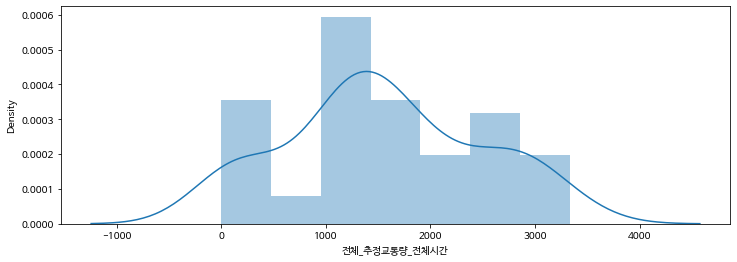

In [83]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체_추정교통량_전체시간'])
plt.rc('axes', unicode_minus=False)
plt.show()

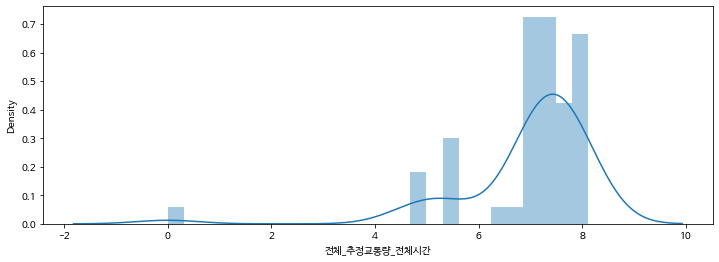

In [84]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체_추정교통량_전체시간']))
plt.rc('axes', unicode_minus=False)
plt.show()

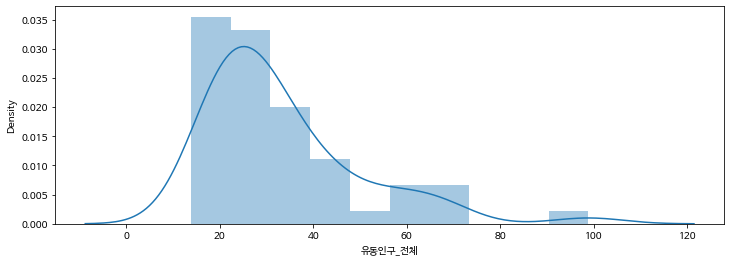

In [85]:
plt.figure(figsize=(12,4))
sns.distplot(Y['유동인구_전체'])
plt.rc('axes', unicode_minus=False)
plt.show()

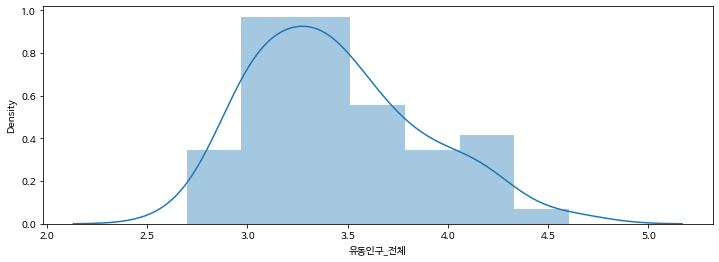

In [86]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['유동인구_전체']))
plt.rc('axes', unicode_minus=False)
plt.show()

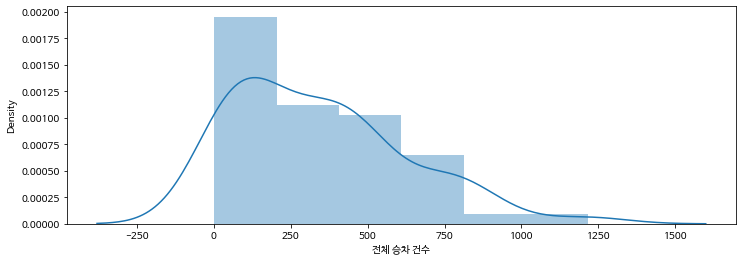

In [87]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체 승차 건수'])
plt.rc('axes', unicode_minus=False)
plt.show()

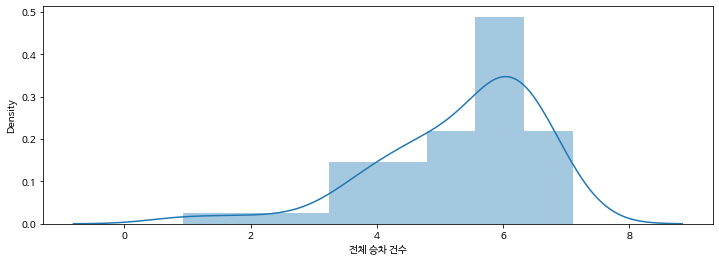

In [88]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체 승차 건수']))
plt.rc('axes', unicode_minus=False)
plt.show()

In [89]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:09<00:00,  4.05it/s]


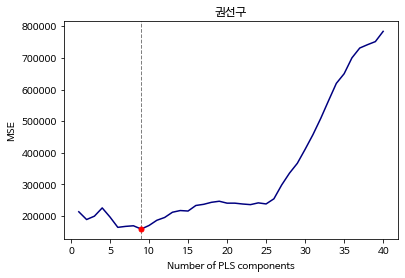

In [90]:
plot_metrics(mses, 'MSE', 'min', '권선구', 9)

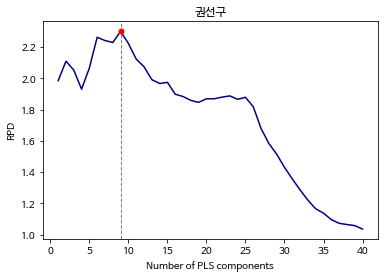

In [91]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '권선구', 9)

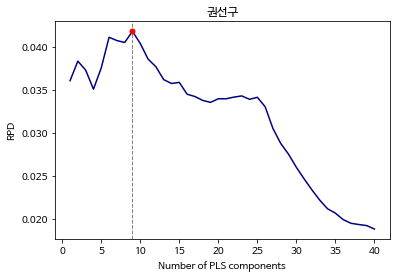

In [92]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '권선구', 9)

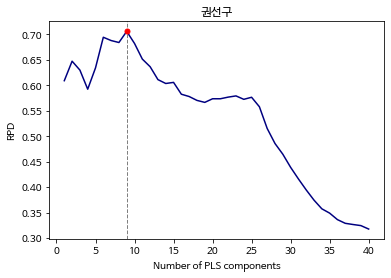

In [93]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '권선구', 9)

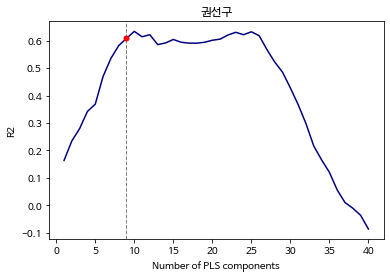

In [94]:
plot_metrics(r2s, 'R2', 'max', '권선구', 9)

In [95]:
pls = PLSRegression(n_components = 9)
pls.fit(X, Y)
y_pred = pls.predict(X)

In [96]:
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
rpd = Y.std()/np.sqrt(mse)

In [97]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.9282, MSE: 31074.2998


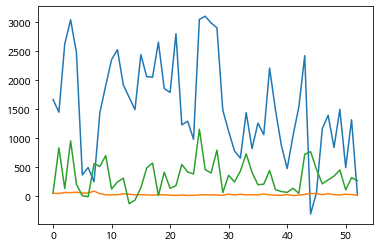

In [98]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

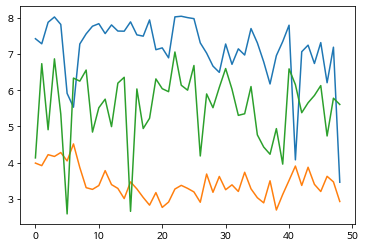

In [99]:
y_pred_plot = pd.DataFrame(y_pred, columns = Y.columns)
y_plot = y_pred_plot[(y_pred_plot['전체_추정교통량_전체시간']>0)&(y_pred_plot['유동인구_전체']>0)&(y_pred_plot['전체 승차 건수']>0)].reset_index(drop = True)
plt.plot(np.log1p(y_plot))
plt.rc('axes', unicode_minus=False)
plt.show()

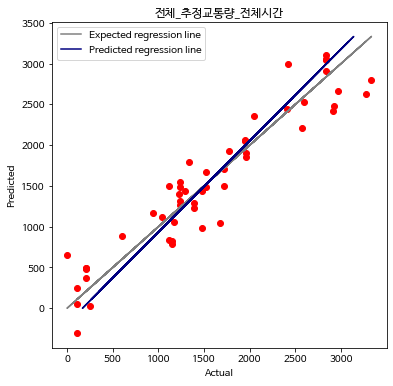

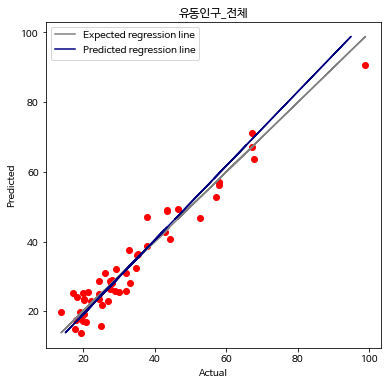

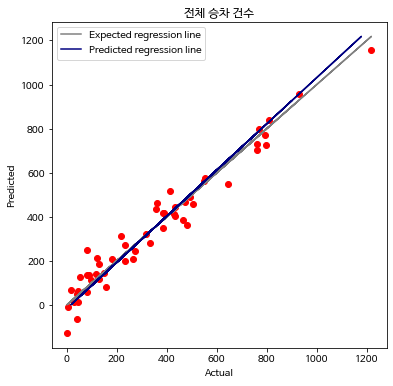

In [100]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(Y).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(Y).iloc[:,i]), pd.DataFrame(Y).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

* 지수 - 원래값

In [101]:
scaler = MinMaxScaler()
yhat_scale = scaler.fit_transform(y_pred)
gs['pred_교통량'] = pd.DataFrame(yhat_scale).iloc[:,0]
gs['pred_유동인구'] = pd.DataFrame(yhat_scale).iloc[:,1]
gs['pred_승차건수'] = pd.DataFrame(yhat_scale).iloc[:,2]
gs['smart'] = gs['pred_교통량'] + gs['pred_유동인구'] + gs['pred_승차건수']

* 로그

In [102]:
gs['log_전체_추정교통량_전체시간'] = np.log1p(gs['전체_추정교통량_전체시간'])
gs['log_유동인구_전체'] = np.log1p(gs['유동인구_전체'])
gs['log_전체_승차_건수'] = np.log1p(gs['전체 승차 건수'])

In [103]:
logY = gs[['log_전체_추정교통량_전체시간', 'log_유동인구_전체', 'log_전체_승차_건수']]
X = gs[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [104]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:10<00:00,  3.97it/s]


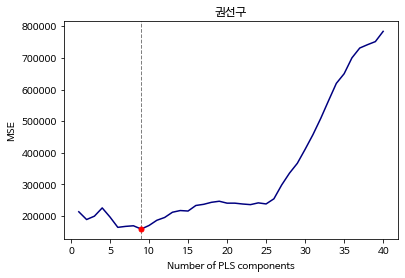

In [105]:
plot_metrics(mses, 'MSE', 'min', '권선구', 9)

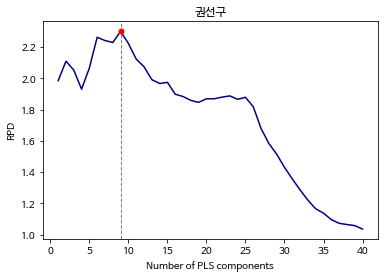

In [106]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '권선구', 9)

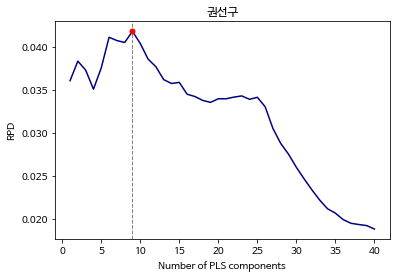

In [107]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '권선구', 9)

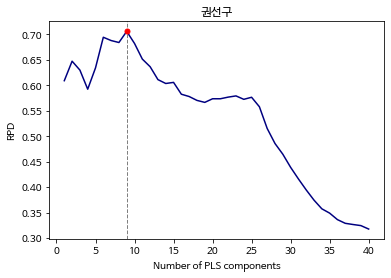

In [108]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '권선구', 9)

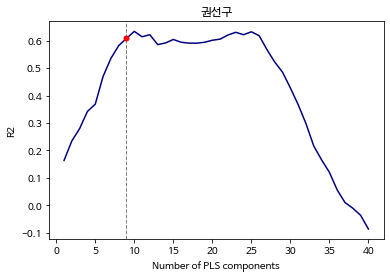

In [109]:
plot_metrics(r2s, 'R2', 'max', '권선구', 9)

In [110]:
pls = PLSRegression(n_components = 9)
pls.fit(X, logY)
y_pred = pls.predict(X)

In [111]:
r2 = r2_score(Y, np.expm1(y_pred))
mse = mean_squared_error(Y, np.expm1(y_pred))
rpd = Y.std()/np.sqrt(mse)

In [112]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.3177, MSE: 452173.6577


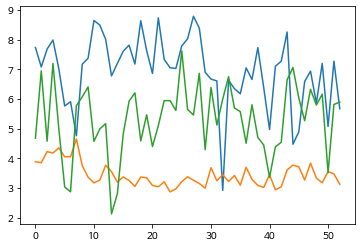

In [113]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

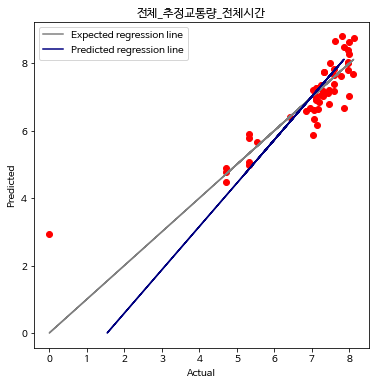

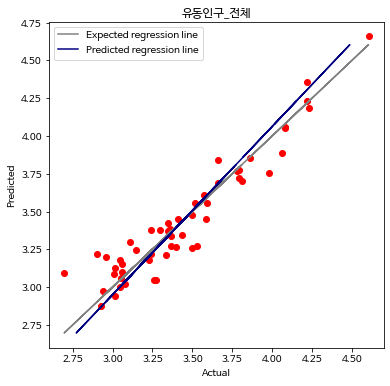

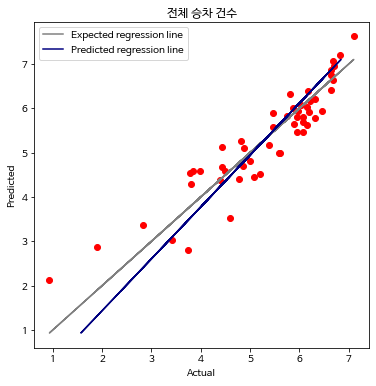

In [114]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(logY).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(logY).iloc[:,i]), pd.DataFrame(logY).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

### 4. 영통구

* 원래 값

In [115]:
yt = yt.rename(columns = {'전체승차건수': '전체 승차 건수'})

In [116]:
Y = yt[['전체_추정교통량_전체시간', '유동인구_전체', '전체 승차 건수']]
X = yt[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [117]:
X.shape

(31, 79)

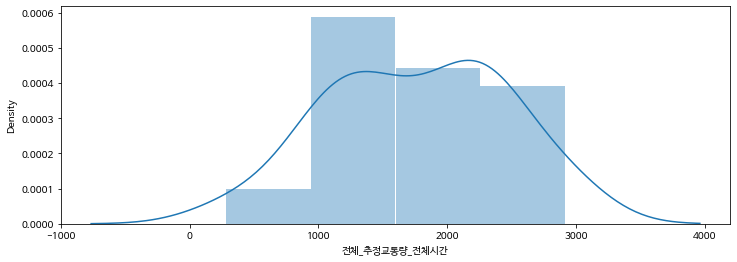

In [118]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체_추정교통량_전체시간'])
plt.rc('axes', unicode_minus=False)
plt.show()

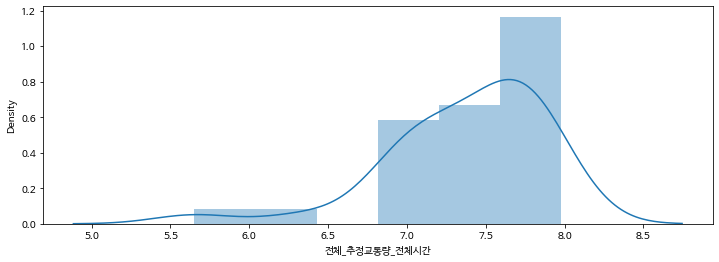

In [119]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체_추정교통량_전체시간']))
plt.rc('axes', unicode_minus=False)
plt.show()

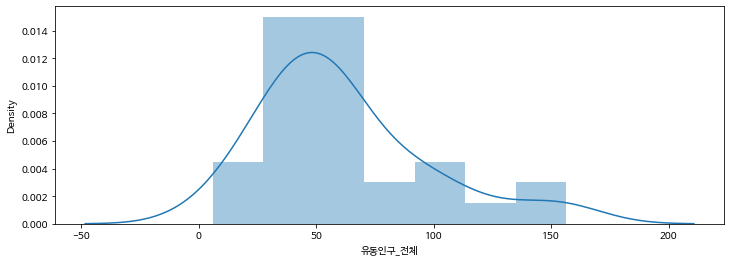

In [120]:
plt.figure(figsize=(12,4))
sns.distplot(Y['유동인구_전체'])
plt.rc('axes', unicode_minus=False)
plt.show()

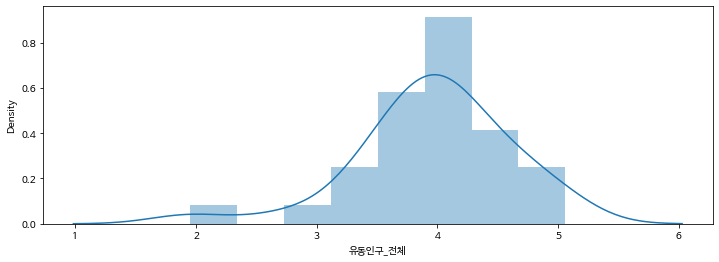

In [121]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['유동인구_전체']))
plt.rc('axes', unicode_minus=False)
plt.show()

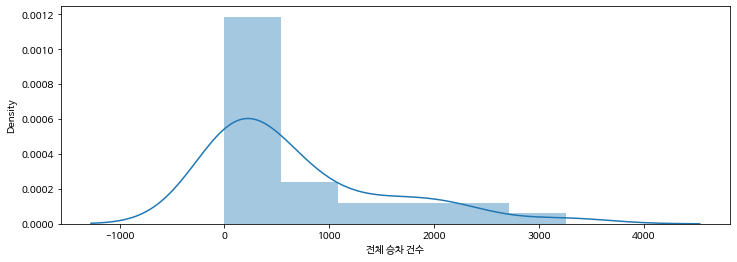

In [122]:
plt.figure(figsize=(12,4))
sns.distplot(Y['전체 승차 건수'])
plt.rc('axes', unicode_minus=False)
plt.show()

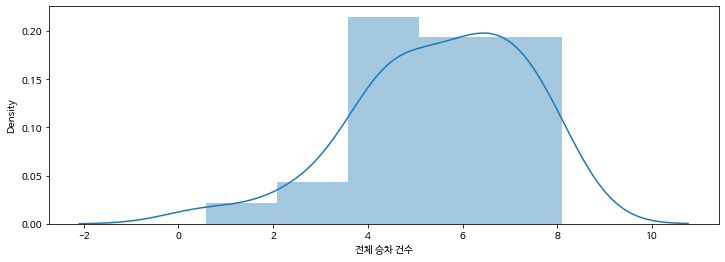

In [123]:
plt.figure(figsize=(12,4))
sns.distplot(np.log1p(Y['전체 승차 건수']))
plt.rc('axes', unicode_minus=False)
plt.show()

In [124]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:05<00:00,  7.35it/s]


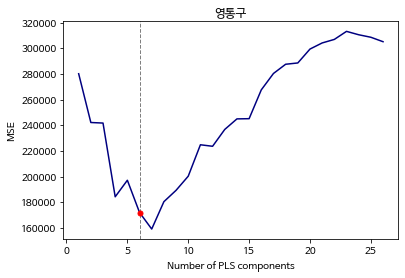

In [125]:
plot_metrics(mses, 'MSE', 'min', '영통구', 6)

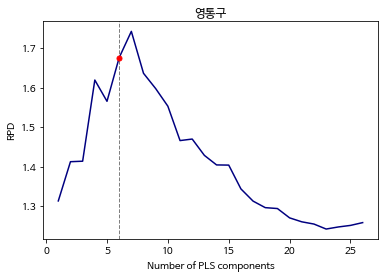

In [126]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '영통구', 6)

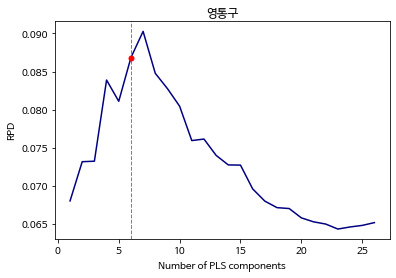

In [127]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '영통구', 6)

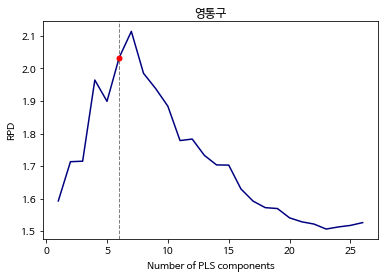

In [128]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '영통구', 6)

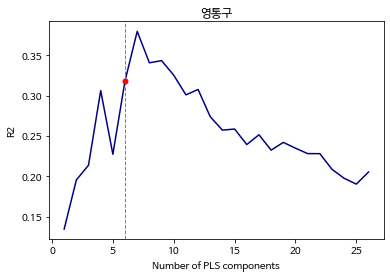

In [129]:
plot_metrics(r2s, 'R2', 'max', '영통구', 6)

In [130]:
pls = PLSRegression(n_components = 6)
pls.fit(X, Y)
y_pred = pls.predict(X)

In [131]:
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
rpd = Y.std()/np.sqrt(mse)

In [132]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.8992, MSE: 42478.2176


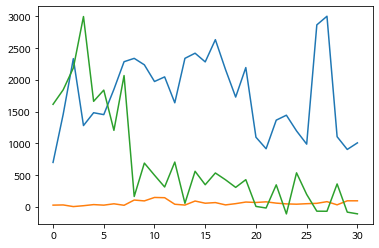

In [133]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

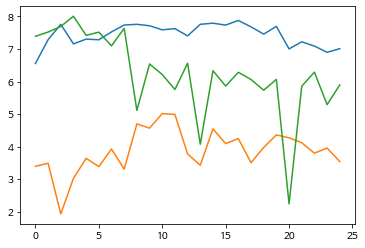

In [134]:
y_pred_plot = pd.DataFrame(y_pred, columns = Y.columns)
y_plot = y_pred_plot[(y_pred_plot['전체_추정교통량_전체시간']>0)&(y_pred_plot['유동인구_전체']>0)&(y_pred_plot['전체 승차 건수']>0)].reset_index(drop = True)
plt.plot(np.log1p(y_plot))
plt.rc('axes', unicode_minus=False)
plt.show()

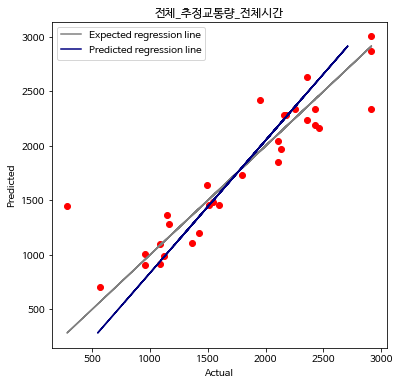

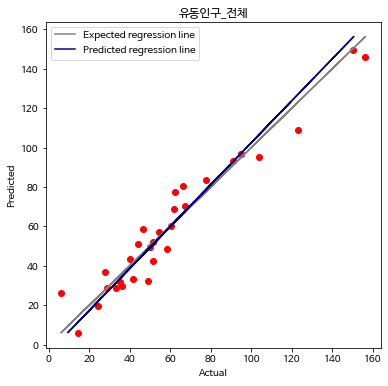

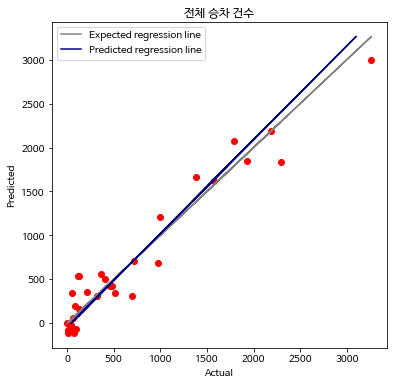

In [135]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(Y).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(Y).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(Y).iloc[:,i]), pd.DataFrame(Y).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

* 지수 - 원래값

In [136]:
scaler = MinMaxScaler()
yhat_scale = scaler.fit_transform(y_pred)
yt['pred_교통량'] = pd.DataFrame(yhat_scale).iloc[:,0]
yt['pred_유동인구'] = pd.DataFrame(yhat_scale).iloc[:,1]
yt['pred_승차건수'] = pd.DataFrame(yhat_scale).iloc[:,2]
yt['smart'] = yt['pred_교통량'] + yt['pred_유동인구'] + yt['pred_승차건수']

* 로그

In [137]:
yt['log_전체_추정교통량_전체시간'] = np.log1p(yt['전체_추정교통량_전체시간'])
yt['log_유동인구_전체'] = np.log1p(yt['유동인구_전체'])
yt['log_전체_승차_건수'] = np.log1p(yt['전체 승차 건수'])

In [138]:
logY = yt[['log_전체_추정교통량_전체시간', 'log_유동인구_전체', 'log_전체_승차_건수']]
X = yt[['쉘터', 'LED', 'LCD', 'LED+LCD복합형', '알뜰형',  '중앙차로여부', '운행노선수',  '정류장유형수', 
              '노선유형_경기순환버스(직행좌석형)', '노선유형_광역급행형시내버스', '노선유형_맞춤형시내버스', 
              '노선유형_일반형시내버스', '노선유형_좌석형시내버스', '노선유형_직행좌석형시내버스', '상행버스정류장운행시간', 
              '하행버스정류장운행시간', '주중배차간격(분)', '주중배차간격_15분', '주중배차간격_60분', '주중배차횟수',  
              '주중대기시간노출도', '평균주중배차간격', '주말배차간격(분)', '주말배차간격_15분', '주말배차간격_60분', '주말배차횟수', 
              '주말대기시간노출도', '평균주말배차간격', '공휴일대기시간노출도', '강수량상관관계', '온도상관관계', '미세먼지상관관계', 
              '미세먼지(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소(ppm)', 
              '아황산가스(ppm)', '일산화탄소(ppm)', '500m내지하철역갯수', '지하철이용객', '미세_봄', '미세_여름',
              '미세_가을', '미세_겨울', '초미세_봄', '초미세_여름', '초미세_가을', '초미세_겨울', '건축년도', '전용면적(㎡)', '층', 
              '거래금액', '면적당 금액', '혼잡빈도강도', '혼잡시간강도','디지털정보지수', '주차구획수', '고령인구', '생산가능인구', 
              '유소년인구', '고령_전체', '생산_전체', '유소년_전체', '500미터내마트개수', '500미터내백화점개수', '500미터내편의점개수', 
              '500미터내카페개수', '500미터내학원개수', '500미터세탁소개수', 
              'nlp_0', 'nlp_1', 'nlp_2', 'nlp_3', 'nlp_4', 'nlp_5', 'nlp_6', 'nlp_7', 'nlp_8', 'nlp_9']]

In [139]:
# test with 40 components
r2s = []
mses = []
rpds = []
xticks = np.arange(1, 41)
for n_comp in tqdm(xticks):
    try : 
        y_cv, r2, mse, rpd = optimise_pls_cv(X, Y, n_comp)
        r2s.append(r2)
        mses.append(mse)
        rpds.append(rpd) 
        
    except : 
        pass

100%|██████████| 40/40 [00:05<00:00,  7.17it/s]


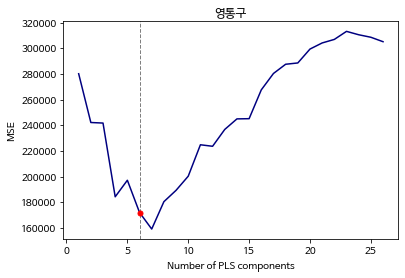

In [140]:
plot_metrics(mses, 'MSE', 'min', '영통구', 6)

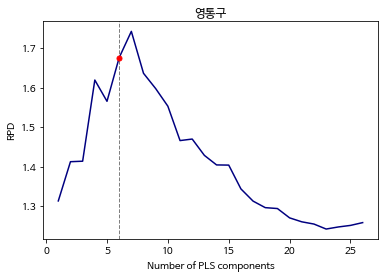

In [141]:
# 전체_추정교통량_전체시간
plot_metrics(pd.DataFrame(rpds).iloc[:,0], 'RPD', 'max', '영통구', 6)

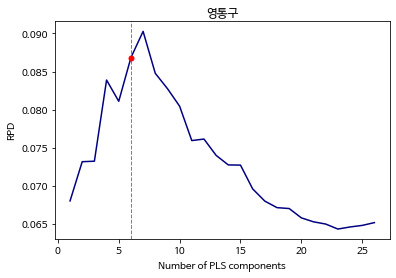

In [142]:
# 유동인구_전체
plot_metrics(pd.DataFrame(rpds).iloc[:,1], 'RPD', 'max', '영통구', 6)

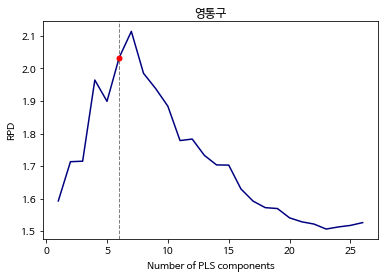

In [143]:
# 전체 승차 건수
plot_metrics(pd.DataFrame(rpds).iloc[:,2], 'RPD', 'max', '영통구', 6)

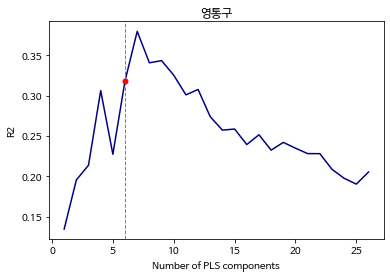

In [144]:
plot_metrics(r2s, 'R2', 'max', '영통구', 6)

In [145]:
pls = PLSRegression(n_components=6)
pls.fit(X, logY)
y_pred = pls.predict(X)

In [146]:
r2 = r2_score(Y, np.expm1(y_pred))
mse = mean_squared_error(Y, np.expm1(y_pred))
rpd = Y.std()/np.sqrt(mse)

In [147]:
# print('R2: %0.4f, MSE: %0.4f, RPD: %0.4f' %(r2, mse, rpd))
print('R2: %0.4f, MSE: %0.4f' %(r2, mse))

R2: 0.4672, MSE: 305186.7680


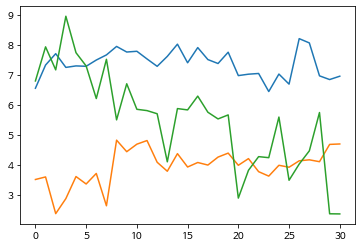

In [148]:
plt.plot(pd.DataFrame(y_pred))
plt.rc('axes', unicode_minus=False)
plt.show()

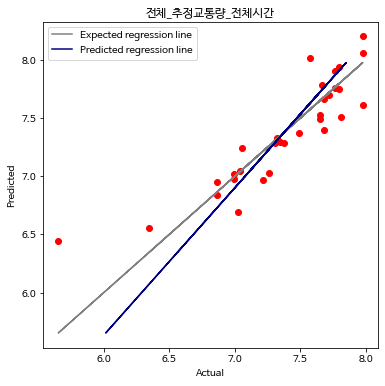

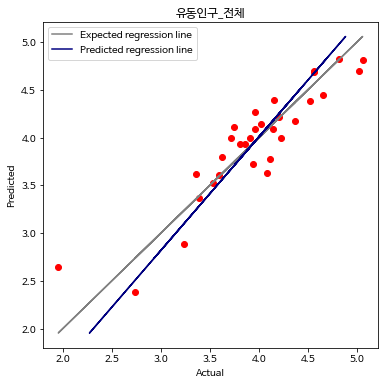

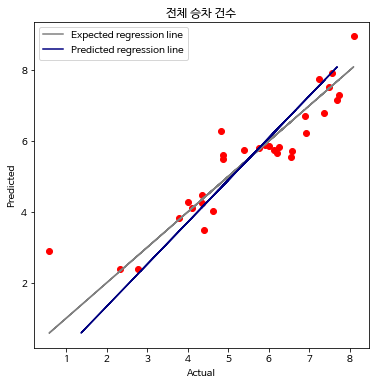

In [149]:
for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.scatter(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], color='red')
    plt.plot(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(logY).iloc[:,i], color = '0.5', label='Expected regression line')
    z = np.polyfit(pd.DataFrame(logY).iloc[:,i], pd.DataFrame(y_pred).iloc[:,i], 1)
    plt.plot(np.polyval(z, pd.DataFrame(logY).iloc[:,i]), pd.DataFrame(logY).iloc[:,i], color='navy', label='Predicted regression line')
    plt.rc('axes', unicode_minus = False)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.title(Y.columns[i])
    plt.show()

### 5. 데이터 병합

In [150]:
paldal.to_excel(current_path+'/busdata/smart_paldal.xlsx', index = False)
jangan.to_excel(current_path+'/busdata/smart_jangan.xlsx', index = False)
gs.to_excel(current_path+'/busdata/smart_gs.xlsx', index = False)
yt.to_excel(current_path+'/busdata/smart_yt.xlsx', index = False)

In [151]:
paldal.head()

,정류소ID,정류장명,lon,lat,위치(동),쉘터,LED,LCD,LED+LCD복합형,알뜰형,중앙차로여부,운행노선수,정류장유형수,초승_환승비율,초승_승차비율,초승_하차비율,환승_승차비율,환승_하차비율,승차_하차비율,승차비율,환승비율,하차비율,전체 승차 건수,초승 건수,환승 건수,전체 하차 건수,노선유형_경기순환버스(직행좌석형),노선유형_광역급행형시내버스,노선유형_맞춤형시내버스,노선유형_일반형시내버스,노선유형_좌석형시내버스,노선유형_직행좌석형시내버스,승차많은버스,환승많은버스,하차많은버스,상행버스정류장운행시간,하행버스정류장운행시간,주중배차간격(분),주중승차비율,주중환승비율,주중하차비율,주중전체승하차건수,주중배차간격_15분,주중배차간격_60분,주중배차횟수,주중승차많은버스,주중환승많은버스,주중하차많은버스,주중대기시간노출도,평균주중배차간격,주말배차간격(분),주말승차비율,주말환승비율,주말하차비율,주말전체승하차건수,주말배차간격_15분,주말배차간격_60분,주말배차횟수,주말승차많은버스,주말환승많은버스,주말하차많은버스,주말대기시간노출도,평균주말배차간격,공휴일승차비율,공휴일환승비율,공휴일하차비율,공휴일전체승하차건수,공휴일승차많은버스,공휴일환승많은버스,공휴일하차많은버스,공휴일대기시간노출도,강수량상관관계,온도상관관계,미세먼지상관관계,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소(ppm),아황산가스(ppm),일산화탄소(ppm),500m내지하철역갯수,지하철이용객,미세_봄,미세_여름,미세_가을,미세_겨울,초미세_봄,초미세_여름,초미세_가을,초미세_겨울,건축년도,전용면적(㎡),층,거래금액,면적당 금액,전체_추정교통량_전체시간,승용차_추정교통량_전체시간,버스_추정교통량_전체시간,화물차_추정교통량_전체시간,혼잡빈도강도,혼잡시간강도,유동인구_전체,유동인구_출퇴근,유동인구_출근,유동인구_퇴근,남자10대유동인구,남자20대유동인구,남자30대유동인구,남자40대유동인구,남자50대유동인구,남자60대유동인구,여자10대유동인구,여자20대유동인구,여자30대유동인구,여자40대유동인구,여자50대유동인구,여자60대유동인구,pop_평일,pop_주말,디지털정보지수,주차구획수,고령인구,생산가능인구,유소년인구,고령_전체,생산_전체,유소년_전체,500미터내마트개수,500미터내백화점개수,500미터내편의점개수,500미터내카페개수,500미터내학원개수,500미터세탁소개수,nlp_0,nlp_1,nlp_2,nlp_3,nlp_4,nlp_5,nlp_6,nlp_7,nlp_8,nlp_9,전체승하차건수,kmeans,spca_component_1,spca_component_2,spca_component_3,log_전체_추정교통량_전체시간,log_유동인구_전체,log_전체_승차_건수,pred_교통량,pred_유동인구,pred_승차건수,smart
0,201000287,매교역4번출구.경기도박치료센터,127.015063,37.265523,경기도 수원시 매교동,1,0,0,1,0,0,5,1,3.827397,0.792482,0.866325,0.207518,0.227554,1.093879,0.413318,0.108385,0.478297,135.810423,108.311571,27.498852,130.443981,0,0,0,3,0,0,0,0,0,17.750000,18.416667,23.500000,0.413929,0.106740,0.479331,301.150813,2,0,294.791444,0,0,0,1411.080046,55.000000,37.833333,0.411326,0.116150,0.472524,193.780000,2,1,192.610101,0,0,0,1341.294231,90.000000,0.428358,0.106404,0.465238,170.611111,0,0,0,1241.472222,0.000625,0.192887,0.010283,39.458333,23.125000,0.027917,0.024917,0.002958,0.562500,1,3872030,48.000000,29.833333,32.333333,47.666667,26.000000,16.333333,17.666667,32.500000,1996,59,4,27000,454,1026.466667,870.653333,8.333333,147.433333,19.075000,50.520000,43.660417,71.615000,64.093333,79.136667,32.430000,97.967500,104.438333,109.963333,112.700833,132.395833,29.766667,103.295833,76.714167,75.082500,78.803333,94.298333,1056.548167,1028.362083,443.737721,0,0,0,0,0.000000,0.000000,0.000000,0,0,5,12,0,6,0,0,0,0,0,1,0,0,0,0,163.309275,2,-5.982865,-0.566526,2.389086,6.934852,3.799088,4.918596,0.242627,0.428456,0.022319,0.693402
1,202000011,중소기업은행,127.033395,37.266237,경기도 수원시 인계동,1,0,0,1,0,0,13,1,4.286277,0.788806,0.401787,0.211194,0.112779,0.514566,0.232416,0.066355,0.701230,809.212526,640.270891,168.941635,1112.889704,0,0,0,7,0,3,0,0,3,19.000000,18.750000,22.350000,0.232281,0.069324,0.698395,2209.304947,4,0,741.822564,0,0,3,9868.925673,45.000000,30.350000,0.234740,0.055074,0.710185,1322.453030,3,2,531.029322,0,0,3,8042.133984,72.500000,0.229927,0.053895,0.716178,1122.005983,0,0,4,6734.994925,-0.043330,0.094638,0.061255,38.791667,24.000000,0.024750,0.027375,0.003000,0.629167,1,3576596,48.166667,25.000000,32.666667,49.333333,27.833333,16.666667,18.000000,33.500000,2014,15,9,7800,519,1575.224000,1323.068000,16.392000,235.732000,33.020000,67.493000,56.932292,75.897222,56.370000,95.424444,36.202500,115.939167,162.910833,178.048333,146.736667,114.762500,42.260833,103.095833,121.162500,151.446667,113.317500,80.479167,1311.896167,1503.891667,630.778358,0,0,101,0,0.000000,1.000000,0.000000,1,1,0,33,0,0,0,0,0,0,0,0,0,0,1,0,978.154162,2,-8.997537,2.574102,1.267798,7.362787,4.059275,6.697297,0.533195,0.733749,0.066453,1.333396
2,202000019,뉴코아아울렛,127.033552,37.265525,경기도 수원시 인계동,1,0,0,1,0,0,13,1,10.025648,0.892851,11.094018,0.107149,0.839893,11.933911,0.650190,0.073253,0.276557,1069.366255,945.032154,124.334100,703.821061,0,0,0,7,0,3,4,0,0,19.000000,18.750000,22.350000,0.646934,0.074879,0.278187,1995.766599,4,0,741.822564,4,0,0,15233.944416,45.000000,30.350000,0.658259,0.068946,0.272795,1308.820638,3,2,531.029322,4,0,0,13708.313050,72.500000,0.671248,0.

In [152]:
print('paldal shape: {}'.format(paldal.shape))
print('jangan shape: {}'.format(jangan.shape))
print('gwonseon shape: {}'.format(gs.shape))
print('yeongtong shape: {}'.format(yt.shape))

paldal shape: (37, 155)
jangan shape: (29, 155)
gwonseon shape: (53, 155)
yeongtong shape: (31, 154)
